## Eksplorativna i statistička analiza novosadskih kompanija prema zvaničnim podacima iz finansijskih izveštaja za 2024. godinu

Obuhvata aktivne kompanije iz Novog Sada koje posluju kao društva sa ograničenom odgovornošću (DOO), prema podacima iz finansijskih izveštaja za 2024. godinu.

Izvor podataka: Agencija za privredne registre Republike Srbije

In [1947]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from scipy.stats import zscore, f_oneway
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:,.2f}'.format

Podaci o novosadskim kompanijama prema podacima iz finansijskih izveštaja za 2024. godinu.

In [1948]:
df = pd.read_parquet("data/novi_sad_2024.parquet")

DataFrame šifara i opisa delatnosti srpske privrede.

In [1949]:
delatnosti_df = pd.read_parquet("data/delatnosti.parquet")

### 1. OSNOVNE INFORMACIJE O DATASETU

In [1950]:
df.shape

(3327, 23)

In [1951]:
df.isna().sum()

MB                   0
PIB                  0
Datum osnivanja      0
Naziv preduzeća      0
Mesto                0
                  ... 
Ebit (EUR)           0
Ebitda (EUR)         0
Email               98
Zastupnik            3
PDV Obveznik       833
Length: 23, dtype: int64

In [1952]:
df.columns

Index(['MB', 'PIB', 'Datum osnivanja', 'Naziv preduzeća', 'Mesto',
       'Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik',
       'Šifra delatnosti', 'Naziv delatnosti', 'APR Status', 'NBS Status',
       'Bonitetna ocena', 'Veličina', 'Promet (EUR)', 'Neto dobit (EUR)',
       'Broj zaposlenih', 'Ebit (EUR)', 'Ebitda (EUR)', 'Email', 'Zastupnik',
       'PDV Obveznik'],
      dtype='object')

### 2. ČIŠĆENJE PODATAKA

- 2.A. Uklanjanje kolona koje sadrže kontakt informacije i kolona sa podacima koji se neće koristiti.
- 2.B. Brisanje 2 zapisa gde veličina nije određena.
- 2.C. Preimenovanje kolona radi lakšeg pozivanja atributa.
- 2.D. Filtriranje šifara delatnosti:
  - Filtriranje retkih delatnosti i onih čija šifra ne može da se podeli na sektor/industriju (count: 48).
  - Svođenje delatnosti na sektor i industrijski nivo.
- 2.E. Uklanjanje kompanija čiji je prihod 0.
- 2.F. Uklanjanje kompanija sa 0 zaposlenih.
- 2.G. Konverzija datuma osnivanja u godinu osnivanja i dodavanje kolone dekada osnivanja.

2.A. Uklanjanje kolona koje sadrže kontakt informacije i kolona sa podacima koji se neće koristiti.

In [1953]:
columns_to_remove = [
    'MB', 'PIB','Mesto','Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik','Naziv delatnosti', 'APR Status', 'NBS Status','Email', 'Zastupnik',
       'PDV Obveznik']

df_cleaned = df.drop(columns=columns_to_remove)

2.B. Brisanje 2 zapisa gde veličina nije određena

In [1954]:
df_cleaned = df_cleaned[df_cleaned['Veličina'].notna()]

2.C. Preimenovanje kolona radi lakšeg pozivanja atributa.

In [1955]:
columns_rename_map = {
    "Datum osnivanja": "godina_osnivanja",
    'Naziv preduzeća': 'naziv',
    'Šifra delatnosti':'sifra_delatnosti',
    'Bonitetna ocena':'bonitet',
    'Veličina': 'velicina',
    'Promet (EUR)': 'prihod',
    'Neto dobit (EUR)': 'neto_dobit',
    'Broj zaposlenih': 'broj_zaposlenih',
    'Ebit (EUR)': 'ebit',
    'Ebitda (EUR)': 'ebitda'
}

df_cleaned = df_cleaned.rename(columns=columns_rename_map)

delatnosti_df = delatnosti_df.rename(columns={'CODE':'sifra','LAT': 'opis'})

df_cleaned.columns

Index(['godina_osnivanja', 'naziv', 'sifra_delatnosti', 'bonitet', 'velicina',
       'prihod', 'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda'],
      dtype='object')

2.D. Filtriranje šifara delatnosti

In [1956]:
# Dodavanje vodeće nule ako je potrebno
df_cleaned['sifra_delatnosti'] = df_cleaned['sifra_delatnosti'].astype(str).str.zfill(4)

# # Filtriranje retkih delatnosti
# delatnosti_counts = df_cleaned['sifra_delatnosti'].value_counts()
# retke_delatnosti = delatnosti_counts[delatnosti_counts < 3].index
# df_cleaned = df_cleaned[~df_cleaned['sifra_delatnosti'].isin(retke_delatnosti)]

# Svođenje delatnosti na sektor i industrijski nivo
df_cleaned['sektor'] = df_cleaned['sifra_delatnosti'].str[:2]
df_cleaned.rename(columns={'sifra_delatnosti': 'industrija'}, inplace=True)

2.E. Uklanjanje kompanija čiji je prihod 0

In [1957]:
df_cleaned = df_cleaned[df_cleaned['prihod'] > 0]

2.F. Uklanjanje kompanija sa 0 zaposlenih.

In [1958]:
df_cleaned = df_cleaned[df_cleaned['broj_zaposlenih'] > 0]

2.G. Konverzija datuma osnivanja u godinu osnivanja i dodavanje kolone dekada osnivanja.

In [ ]:
df_cleaned['godina_osnivanja'] = pd.to_datetime(df_cleaned['godina_osnivanja'], format='%d.%m.%Y').dt.year
df_cleaned['dekada_osnivanja'] = (df_cleaned['godina_osnivanja'] // 10) * 10

In [1960]:
df_cleaned.sample(n=5, random_state=42)

,godina_osnivanja,naziv,industrija,bonitet,velicina,prihod,neto_dobit,broj_zaposlenih,ebit,ebitda,sektor,dekada_osnivanja
1720,2003,PROOF-CLEAN,4743,C2,Mikro,18595,-41199,1,-11955,-11819,47,2000
200,2016,SYNERGY AGRO DOO NOVI SAD,0146,C1,Malo,2055789,35721,4,172943,196265,01,2010
244,1987,PSS POLJOPRIVREDNA STANICA DOO NOVI SAD,7219,B1,Malo,1574030,176011,42,218613,262752,72,1980
2401,2020,NOBU TECHWAY,7311,D3,Mikro,63778,811,5,-6964,-3512,73,2020
1710,2024,MARHI CUBE DOO,7112,B1,Mikro,19988,7887,1,9280,9280,71,2020


### 3. KONSTRUKCIJA DODATNIH KARAKTERISTIKA (feature engineering)

- 3.A. Vrednost operativnih rashoda
- 3.B. Vrednost amortizacije
- 3.C. marže [neto marža, ebit marža. ebitda marža]
- 3.D. Marža amortizacije
- 3.E. Marža kamata i poreza

In [1961]:
df_features = df_cleaned.copy().reset_index()
del df_cleaned

#### 3.A. Operativni rashodi

Operativni rashodi predstavljaju ukupne troškove poslovanja kompanije koji nastaju tokom osnovne poslovne aktivnosti, bez uzimanja u obzir amortizacije, kamate i poreza. Izračunavaju se kao razlika između prihoda i EBITDA, što omogućava bolji uvid u troškove koji se direktno odnose na proizvodne i operativne procese. Upoređujući operativne rashode između različitih kompanija, možemo dobiti uvid u efikasnost njihovih operacija i način na koji upravljaju svojim troškovima.

In [1962]:
df_features['operativni_rashodi'] = round(df_features.prihod - df_features.ebitda, 2)

#### 3.B. Vrednost amortizacije

Amortizacija predstavlja raspodelu troška kapitalnih ulaganja kroz vreme i obuhvata smanjenje vrednosti dugoročne imovine. Izračunava se kao razlika između EBITDA i EBIT. Analizirajući vrednost amortizacije, možemo proceniti kapitalnu intenzivnost poslovanja kompanije i razumeti kako njena ulaganja u imovinu utiču na finansijske performanse. Upoređujući amortizaciju među kompanijama, možemo uočiti razlike u pristupima kapitalnim ulaganjima i njihovim efektima na profitabilnost.

In [1963]:
df_features['amortizacija'] = round(df_features.ebitda - df_features.ebit, 2)

#### 3.C. Marže

##### 3.C.1. Neto marža

Neto marža pokazuje koliko profita ostaje od svaka 100 jedinica prihoda nakon što se oduzmu svi troškovi, porezi i kamate. Upoređujući neto marže između kompanija, možemo utvrditi koja je kompanija efikasnija u konverziji prihoda u čist profit.

In [1964]:
df_features['net_marza'] = round(df_features.neto_dobit / df_features.prihod, 2)

##### 3.C.2. EBIT marža

EBIT marža pokazuje koliko od svaka 100 jedinica prihoda ostaje nakon operativnih troškova, pre kamata i poreza. Viša EBIT marža pokazuje da je kompanija efikasnija u generisanju profita iz osnovne delatnosti.

In [1965]:
df_features['ebit_marza'] = round(df_features.ebit / df_features.prihod, 2)

##### 3.C.3. EBITDA marža

Upoređivanje EBITDA marže pomaže u proceni koja kompanija ima bolju osnovnu operativnu efikasnost, pre nego što se oduzmu negotovinski troškovi kao što je amortizacija. Ovo je posebno korisno za upoređivanje kompanija sa različitim strukturama kapitala ili onih koje posluju u industrijama koje zahtevaju velika ulaganja u opremu, infrastrukturu i dugoročne resurse, kao što su industrija proizvodnje, energetika, telekomunikacije i građevina.

In [1966]:
df_features['ebitda_marza'] = round(df_features.ebitda / df_features.prihod, 2)

##### 3.C.4. Marža amortizacije

Razlika između EBITDA i EBIT, izražena kao procenat prihoda, pokazuje koliki deo ostvarenog prihoda se troši na amortizaciju osnovnih sredstava. Ova marža daje uvid u stepen zavisnosti poslovanja od dugotrajne imovine, poput opreme, mašina i objekata. Viša marža ukazuje na kapitalno intenzivnije poslovanje i veća ulaganja u imovinu koja se vremenom troši.

In [1967]:
df_features['marza_amortizacije'] = round((df_features.ebitda - df_features.ebit) / df_features.prihod * 100, 2)

##### 3.C.5. Marža kamata i poreza

Razlika između EBIT-a i neto profita pokazuje koliki iznos prihoda se troši na kamate i poreze. Ova vrednost omogućava uvid u finansijsko i poresko opterećenje poslovanja. Veći iznosi ukazuju na veće dugove ili viši poreski teret, što može značajno uticati na konačnu profitabilnost kompanije.

In [1968]:
df_features['marza_kamate_poreza'] = round((df_features.ebit - df_features.neto_dobit) / df_features.prihod * 100, 2)

In [1969]:
df_features.columns

Index(['index', 'godina_osnivanja', 'naziv', 'industrija', 'bonitet',
       'velicina', 'prihod', 'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda',
       'sektor', 'dekada_osnivanja', 'operativni_rashodi', 'amortizacija',
       'net_marza', 'ebit_marza', 'ebitda_marza', 'marza_amortizacije',
       'marza_kamate_poreza'],
      dtype='object')

### 4. EKSPLORATIVNA, STATISTIČKA ANALIZA I VIZUELIZACIJA REZULTATA

PRIPREMA PODATAKA






Napomena o interpretaciji rezultata: 
Sve analize u ovom projektu imaju za cilj da istraže povezanost između pojedinačnih poslovnih pokazatelja kompanija iz Novog Sada. Iako određeni rezultati pokazuju statistički značajne povezanosti, važno je naglasiti da ove analize ne određuju uzročno-posledične odnose, niti identifikuju presudne faktore. Prikazani rezultati pružaju uvid u obrasce koji zaslužuju dodatnu, dublju analizu, uključujući i druge finansijske, operativne i tržišne aspekte poslovanja.

Pored ograničenja u interpretaciji uzročno-posledičnih odnosa, važno je napomenuti da pojedine informacije nisu direktno dostupne u skupu podataka, već su izvedene na osnovu dostupnih finansijskih pokazatelja, zato njihovu tačnost treba tumačiti uslovno, imajući u vidu ograničenja izvora podataka.

Svi iznosi su u hiljadama RSD.

#### Sadržaj:

- 4.A. PREGLED DISTRIBUCIJE KOMPANIJA PO BROJČANOSTI
    - 4.A.1. Prema veličini
    - 4.A.2. Prema bonitetu
    - 4.A.3. Prema dekadi osnivanja

- 4.B SEKTORI PRIVREDE
    - 4.B.1. Najzastupljeniji sektori novosadskih kompanija.
    - 4.B.2. Najzastupljeniji sektori novosadskih kompanija prema veličini kompanije.
    - 4.B.3. Sektori sa najvišim i najnižim prosečnim prihodima. koristim medijanu da eliminišem uticaj outliera
    - 4.B.4. Sektori sa najvišim i najnižim prihodima po zaposlenom.
    - 4.B.5. Sektori sa najvišim i najnižim prosečnim rashodima.  ---prihod - EBITDA = operativni rashodixxxxxxxxxxxxxxxxx
    - 4.B.6. Sektori sa najvišim i najnižim rashodima po zaposlenom.
    - 4.B.7. Najprofitabilniji i najmanje profitabilni sektori.
    - 4.B.8. Sektori sa najvišim i najnižim neto maržama. 
    - 4.B.9. Sektori sa najvišim i najnižom prosečnom amortizacijom. -- ovo mora biti uradjeno umkodu izlistam sve sektore onda ya svaki uradi medijanu nova kolona onda sortiram i izaberem 5
    - 4.B.10. Pregled kompanija po izabranom sektoru 

- 4.C. Prihodi
    - 4.C.1. Distribucija prihoda -- kao normalna raspodela
    - 4.C.2. Prihodi prema veličini kompanije. -- OK - bar plot
    - 4.C.3. Distribucija prihoda kompanija prema veličini. -- Stripplot, scatter ili violin, radije neki gradijent u bojama gde je svaka boja veličina a gradient vrednost prihoda
    - 4.C.4. Prihodi prema broju zaposlenih. -- OK
    - 4.C.5. Povezanost između prihoda i broja zaposlenih -- ovde bih radije primenio neku statistiku koja mi govori koliko je pobećanje broja zaposlenih bilo učinkovito
    - 4.C.5. Analiza izolovanih slučajeva (outlier) ---- Sektor sa najvećim brojem outlier-a i njihovo prosečno odstupanje od proseka sektora.

- 4.D. Rashodi
    - 4.D.1. Distribucija rashoda
    - 4.D.2. Rashodi prema veličini kompanije. 
    - 4.D.3. Analiza izolovanih slučajeva (outlier)

- 4.E. Neto dobit
    - 4.E.2. Neto dobit i broj zaposlenih. -- da li je optimalna utilitizacija zaposlenih u konververziji prihoda u neto dobit
    - 4.E.5. Pregled 10 najprofitabilnijih novosadskih kompanija i sektor kom pripadaju
    - 4.E.3. Gradijentno grupisanje profitabilnosti i veličine kompanija
    - 4.C.3. Analiza izolovanih slučajeva (outlier): kompanije sa ekstremno visokim prihodom, ali niskom neto maržom.

- 4.D. Amortizacija -- kao pokazatelj kapitalnih investiranja -- EBITDA = EBIT + Amortizacija + Deprecijacija
    - 4.D.1. Analiza povezanosti vrednosti amortizacije i prihoda, po sektoru, veličini i bonitetu --- - Scatter plot: amortizacija vs prihod (log-skala ako ima outliera) i korelacija+
    - 4.D.2. Prosečan neto povraćaj na kapitalna ulaganja. KPI: neto_dobit / amortizacija
    - 4.D.3. Vrednost kapitalnih ulaganja po sektoru. --- da li je proizvodnja više kapitalno intenzivna od usluga

- E. Marže poslovanja
    - 4.E.1. Neto marža. dekada osnivanja, sektor i industrija poslovanja
    - 4.E.2. EBIT marža. veličina, bonitet, sektor i industrija poslovanja
    - 4.E.3. EBITDA marža: veličina, bonitet, sektor i industrija poslovanja
    - 4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja
    - 4.E.5. Marža kamate i poreza. veličina i sektor poslovanja.
    - Marža kamate i poreza prema industriji poslovanja -- Koliko je kapitalno ulaganje vezano za industriji kompanije
    - Koji su najuticajniji faktori na vrednost neto marže (npr. veličina kompanije, sektor, kapitalna ulaganja, broj zaposlenih) -- Vizualizacija: Višestruki bar plot-ovi ili box plot-ovi za podelu po sektoru i veličini.

- F. Zaposleni
    - 4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.
    - 4.F.2. Test normalne distribucije zaposlenih po prihodima ------ Predlog: Kod “test normalnosti”, koristi histogram + Shapiro-Wilk test (ili Anderson-Darling), po grupama prihoda.
    - 4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.
    - 4.F.4. Prosečan broj zaposlenih prema dekadi osnivanja.

- XXX. Ostalo Komparativna analiza 
    - performanse novih vs. starijih kompanija i vidiš kako se ponašaju po sektoru, veličini i bonitetu. Pomoću pair plots ili scatter matrix možeš vizualizovati ove komparativne analize.

- H. Klaster analiza.


In [1970]:
df_analysis = df_features.copy()

#### 4.A. PREGLED DISTRIBUCIJE KOMPANIJA PO BROJČANOSTI

Ovim pregledima dobijamo uvid u brojčanu i strukturnu raspodelu kompanija u Novom Sadu. Prikazuje se kako su firme klasifikovane prema veličini, što otkriva zastupljenost mikro, malih, srednjih i velikih preduzeća u lokalnoj privredi. Analiza boniteta osvetljava finansijsku stabilnost firmi, dok raspodela po dekadama osnivanja pokazuje kada su nastajale kompanije,. Ukupno, ove analize služe kao polazna tačka za razumevanje poslovnog pejzaža grada.

4.A.1. Prema veličini

C:\Users\Nivian\AppData\Local\Temp\ipykernel_12564\3390812010.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


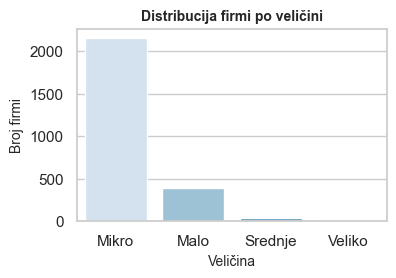

In [1971]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='velicina',
    palette='Blues',
    order=['Mikro', 'Malo', 'Srednje', 'Veliko'],
    legend=False
)

plt.title('Distribucija firmi po veličini', fontsize=10, fontweight='bold')
plt.xlabel('Veličina', fontsize=10)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

4.A.2. Prema bonitetu

C:\Users\Nivian\AppData\Local\Temp\ipykernel_12564\1067782011.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


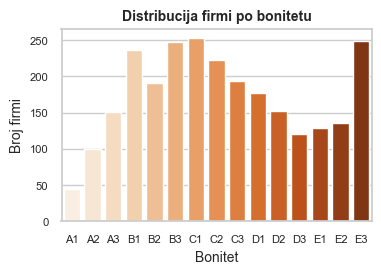

In [1972]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='bonitet',
    palette='Oranges',
    order=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E1', 'E2', 'E3'],
    legend=False
)

plt.title('Distribucija firmi po bonitetu', fontsize=10, fontweight='bold')
plt.xlabel('Bonitet', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

4.A.3. Prema dekadi osnivanja

C:\Users\Nivian\AppData\Local\Temp\ipykernel_12564\872083138.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


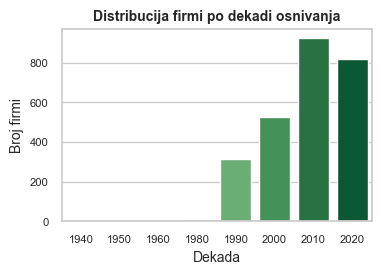

In [1973]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='dekada_osnivanja',
    palette='YlGn',
    legend=False
)

plt.title('Distribucija firmi po dekadi osnivanja', fontsize=10, fontweight='bold')
plt.xlabel('Dekada', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

#### 4.B. SEKTOR I INDUSTRIJA

In [1974]:
# Agregacija po sektoru
freq_sectors = df_analysis['sektor'].value_counts().head(10).reset_index()
freq_sectors = freq_sectors.merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
freq_sectors['opis'] = "(" + freq_sectors['sektor']  +") " + freq_sectors['opis'].str.split('[,;]').str[0]
freq_sectors.drop(columns=['sifra'], inplace=True)

# 1. Prosečni prihodi
prihod_po_sektoru = df_analysis.groupby('sektor')['prihod'].mean()
freq_sectors['prosecni_prihod'] = freq_sectors['sektor'].map(prihod_po_sektoru)

# Zaposleni
zaposleni_po_sektoru = df_analysis.groupby('sektor')['broj_zaposlenih'].sum()

# 2. Prosečan prihod po zaposlenom
freq_sectors['prosecni_prihod_po_zaposlenom'] = freq_sectors['prosecni_prihod'] / freq_sectors['sektor'].map(zaposleni_po_sektoru)

# Prihodi
# freq_sectors['prosecni_prihod'] = df_analysis.groupby('sektor')['prihod'].mean()
# prihod_sum = df_analysis.groupby('sektor')['prihod'].sum().reset_index()
# freq_sectors = freq_sectors.merge(prihod_sum, on='sektor', how='left')
# freq_sectors['prihodi'] = df_analysis['prihod']
# freq_sectors['prihodi_po_zaoposlenima'] = df_analysis['prihod']/df_analysis['broj_zaposlenih']
# freq_sectors['operativni_rashodi'] = df_analysis['operativni_rashodi']
# freq_sectors['rashodi_po_zaoposlenima'] = df_analysis['operativni_rashodi']/df_analysis['broj_zaposlenih']
# freq_sectors['neto_dobit'] = df_analysis['neto_dobit']
# freq_sectors['neto_marza'] = df_analysis['net_marza']

# ovo nije dobro svaki novi feature mora biti napravljen sa groupby
# freq_sectors = freq_sectors.drop(columns=['sifra'])
freq_sectors

,sektor,count,opis,prosecni_prihod,prosecni_prihod_po_zaposlenom
0,46,472,(46) Trgovina na veliko,"3,799,108.29","1,095.16"
1,62,317,(62) Računarsko programiranje,"488,342.81",210.22
2,71,144,(71) Arhitektonske i inženjerske delatnosti,"514,306.12",404.33
3,70,141,(70) Upravljačke delatnosti,"222,140.21",437.28
4,41,135,(41) Izgradnja zgrada,"2,313,411.61","1,755.24"
5,49,113,(49) Kopneni saobraćaj i cevovodni transport,"2,981,937.08","2,794.69"
6,56,112,(56) Delatnost pripremanja i posluživanja hran...,"480,248.26",447.58
7,43,112,(43) Specijalizovani građevinski radovi,"634,375.10",699.42
8,47,107,(47) Trgovina na malo,"1,338,841.77","1,569.57"
9,52,81,(52) Skladištenje i prateće aktivnosti u saobr...,"954,235.46","2,069.93"


4.B.1. Najzastupljeniji sektori novosadskih kompanija.

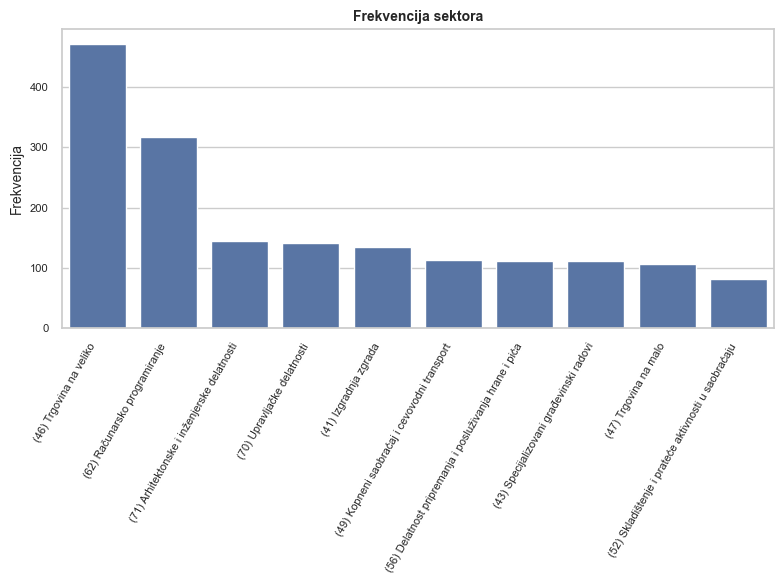

In [1975]:
freq_sectors = df_analysis['sektor'].value_counts().head(10).reset_index()
freq_sectors = freq_sectors.merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
freq_sectors['opis'] = "(" + freq_sectors['sektor']  +") " + freq_sectors['opis'].str.split('[,;]').str[0]
freq_sectors = freq_sectors.drop(columns=['sifra', "sektor"])
# freq_sectors['opis'] = freq_sectors['opis'].str.split('[,;]').str[0]

plt.figure(figsize=[8,6])

sns.barplot(data=freq_sectors, x='opis', y='count')

plt.title('Frekvencija sektora', fontsize=10, fontweight='bold') 
plt.xlabel("")
plt.xticks(rotation=60, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Frekvencija', fontsize=10)
plt.tight_layout()  
plt.show()



4.B.2. Sektori sa najvišim i najnižim prosečnim prihodima. 

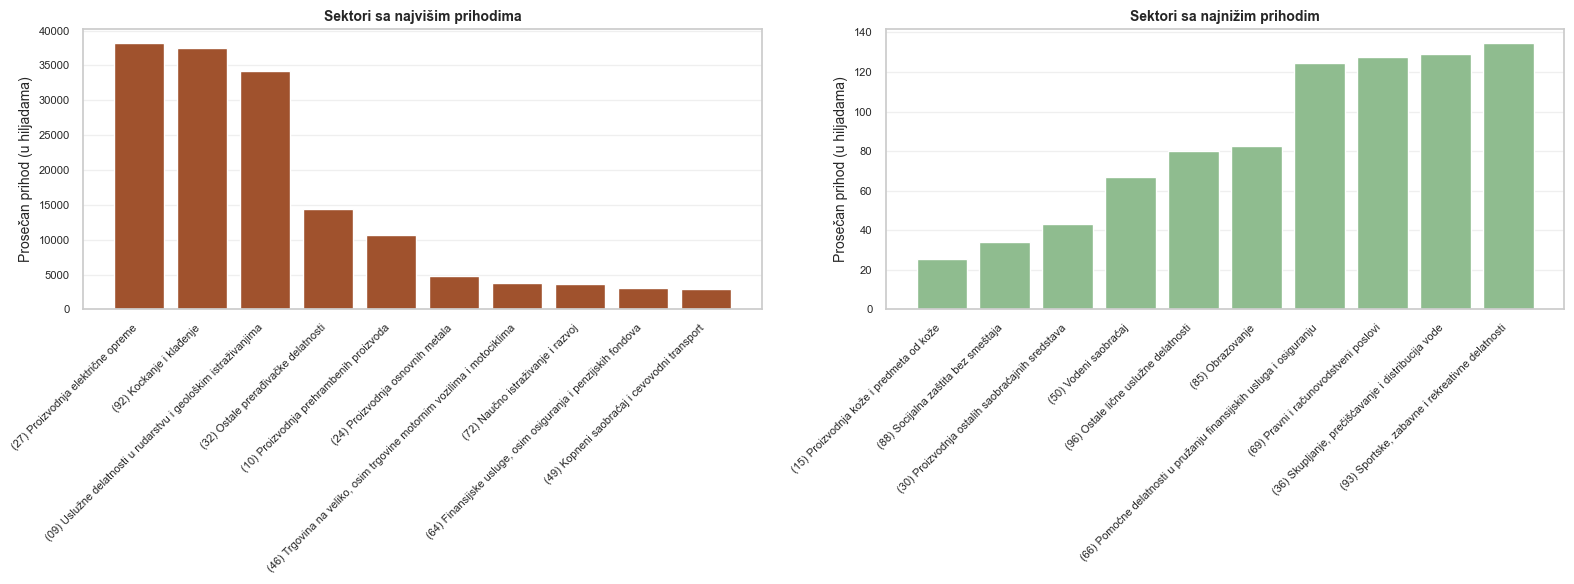

In [1976]:
freq_sectors_prihodi = df_analysis.groupby('sektor')['prihod'].mean().reset_index()

freq_sectors_hi_prihodi = freq_sectors_prihodi.sort_values(by='prihod', ascending=False).head(10).reset_index(drop=True)
freq_sectors_hi_prihodi = freq_sectors_hi_prihodi.merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
freq_sectors_hi_prihodi['opis'] =  "(" + freq_sectors_hi_prihodi['sektor']  +") " + freq_sectors_hi_prihodi['opis']
freq_sectors_hi_prihodi['prihod'] = freq_sectors_hi_prihodi['prihod'] / 1000

freq_sectors_low_prihodi = freq_sectors_prihodi.sort_values(by='prihod', ascending=True).head(10).reset_index(drop=True)
freq_sectors_low_prihodi = freq_sectors_low_prihodi.merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
freq_sectors_low_prihodi['opis'] =  "(" + freq_sectors_low_prihodi['sektor']  +") " + freq_sectors_low_prihodi['opis']
freq_sectors_low_prihodi['prihod'] = freq_sectors_low_prihodi['prihod'] / 1000


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(freq_sectors_hi_prihodi['opis'], freq_sectors_hi_prihodi['prihod'], color='Sienna')
ax1.set_title('Sektori sa najvišim prihodima', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prosečan prihod (u hiljadama)', fontsize=10)
ax1.set_xticks(range(len(freq_sectors_hi_prihodi['opis'])))
ax1.set_xticklabels(freq_sectors_hi_prihodi['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(freq_sectors_low_prihodi['opis'], freq_sectors_low_prihodi['prihod'], color='DarkSeaGreen')
ax2.set_title('Sektori sa najnižim prihodim', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prosečan prihod (u hiljadama)', fontsize=10)
ax2.set_xticks(range(len(freq_sectors_low_prihodi['opis'])))
ax2.set_xticklabels(freq_sectors_low_prihodi['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


4.B.3. Sektori i industrije sa najvišim i najnižim prosečnim prihodima po zaposlenom.

In [1977]:
freq_sectors['prihodi'] = df_analysis['prihod']
freq_sectors['prihodi_po_zaoposlenima'] = df_analysis['prihod']/df_analysis['broj_zaposlenih']
freq_sectors['operativni_rashodi'] = df_analysis['operativni_rashodi']
freq_sectors['rashodi_po_zaoposlenima'] = df_analysis['operativni_rashodi']/df_analysis['broj_zaposlenih']
freq_sectors['neto_dobit'] = df_analysis['neto_dobit']
freq_sectors['neto_marza'] = df_analysis['net_marza']

freq_sectors

,count,opis,prihodi,prihodi_po_zaoposlenima,operativni_rashodi,rashodi_po_zaoposlenima,neto_dobit,neto_marza
0,472,(46) Trgovina na veliko,873468900,"818,621.27",855913709,"802,168.42",10156706,0.01
1,317,(62) Računarsko programiranje,222077949,"53,863.19",204727193,"49,654.91",9142177,0.04
2,144,(71) Arhitektonske i inženjerske delatnosti,207061528,"1,882,377.53",53163145,"483,301.32",42239253,0.20
3,141,(70) Upravljačke delatnosti,200362116,"121,431.59",185041179,"112,146.17",10329154,0.05
4,135,(41) Izgradnja zgrada,142235928,"60,836.58",130537991,"55,833.19",53335,0.00
5,113,(49) Kopneni saobraćaj i cevovodni transport,111122156,"172,818.28",74088480,"115,223.14",28851565,0.26
6,112,(56) Delatnost pripremanja i posluživanja hran...,96969189,"216,933.31",88005639,"196,880.62",4921646,0.05
7,112,(43) Specijalizovani građevinski radovi,80474264,"365,792.11",40150776,"182,503.53",10416459,0.13
8,107,(47) Trgovina na malo,74455688,"69,845.86",54005361,"50,661.69",8348270,0.11
9,81,(52) Skladištenje i prateće aktivnosti u saobr...,74318287,"3,911,488.79",72762178,"3,829,588.32",669111,0.01


4.B.4. Sektori i industrije sa najvišim i najnižim prosečnim operativnim rashodima.

In [1978]:
# prihod - EBITDA = operativni rashodixxxxxxxxxxxxxxxxx

4.B.5. Sektori i industrije sa najvišim i najnižim rashodima po zaposlenom.

4.B.6. Najprofitabilniji i najmanje profitabilni sektori i industrije.

4.B.7. Sektori i industrije sa najvišim i najnižim neto maržama. 

4.B.8. Sektori i industrije sa najvišim i najnižom amortizacijom. 

In [1979]:
### Prosečnom ili veličina ovo valjda treba da bude homogenizovano ili 

4.B.10. Pregled kompanija po izabranom sektoru

In [1980]:
sektori = pd.DataFrame(sorted(df_analysis['sektor'].unique().tolist()), columns=['Sektori'])
sektori = sektori.merge(delatnosti_df[['sifra', 'opis']], left_on='Sektori', right_on='sifra', how='left')
sektori = sektori.drop(columns=['sifra'])

sektori = sektori.merge(df_analysis[['sektor', 'naziv', 'prihod', 'velicina', 'net_marza']], left_on='Sektori', right_on='sektor', how='left')
sektori = sektori.drop(columns=['Sektori'])
sektori = sektori.sort_values(by='prihod', ascending=False)

-- Izaberi ključnu reč za pretragu šifre sektora

In [1981]:
kriterijum_pretrage = 'prog'

In [1982]:
filtered_sektori = sektori[sektori['opis'].str.contains(kriterijum_pretrage, case=False, na=False)]

# Kreiraj rečnik sa sektorom kao ključem i opisom kao vrednošću
sektori_dict = dict(zip(filtered_sektori['sektor'], filtered_sektori['opis']))

for sektor, opis in sektori_dict.items():
    print(f"{sektor}: {opis}")

62: Računarsko programiranje, konsultantske i s tim povezane delatnosti
60: Programske aktivnosti i emitovanje


-- Izaberi šifru sektora od 1-96. 

In [1983]:
# Unesi sifru sektora (integer)
Sifra_sektora = 8

In [1984]:
sektori = pd.DataFrame(sorted(df_analysis['sektor'].unique().tolist()), columns=['Sektori'])
sektori = sektori.merge(delatnosti_df[['sifra', 'opis']], left_on='Sektori', right_on='sifra', how='left')
sektori = sektori.drop(columns=['sifra'])

sektori = sektori.merge(df_analysis[['sektor', 'naziv', 'prihod', 'velicina', 'net_marza']], left_on='Sektori', right_on='sektor', how='left')
sektori = sektori.drop(columns=['Sektori'])
sektori = sektori.sort_values(by='prihod', ascending=False)

Sifra_sektora = str(Sifra_sektora)
if len(Sifra_sektora) == 1:
    Sifra_sektora = '0' + Sifra_sektora

if Sifra_sektora.isdigit() and 1 <= int(Sifra_sektora) <= 96 and Sifra_sektora in df_analysis['sektor'].astype(str).values:
    sektor_df = sektori[sektori['sektor'] == Sifra_sektora]
    print(f"SEKTOR: {sektor_df['opis'].iloc[0]}")
    print('Kompanije: ')
    for _, row in sektor_df.iterrows():
        print(f"Kompanija: {row['naziv']}")
        print(f"Veličina: {row['velicina']}")
        print(f"Prihod: {row['prihod']:,.0f}")
        print(f"Neto marža: {round(row['net_marza'] * 100, 2)}%")
        print("----------------")
else:
    print('Unos nije validan. Unesite broj između 01 i 96.')

SEKTOR: Ostalo rudarstvo
Kompanije: 
Kompanija: GRANODIORIT-KRUP
Veličina: Mikro
Prihod: 161,039
Neto marža: 17.0%
----------------


#### 4.A. PRIHODI

4.A.1. PRIHODI PREMA VELIČINI KOMPANIJE

Prihod se analizira u odnosu na veličinu kompanije kako bi se utvrdilo da li postoje značajne razlike u distribuciji prihoda između različitih kategorija veličine. Za procenu povezanosti koristi se jednofaktorska analiza varijanse (ANOVA), dok se raspodela vizualizuje putem box plotova.

Nulta hipoteza (H₀): Nema značajne razlike u prihodima između različitih kategorija veličine kompanija.

Alternativna hipoteza (H₁): Postoje značajne razlike u prihodima između različitih kategorija veličine kompanija.

In [1985]:
# # priprema podataka
# df_analysis['velicina_kod'] = df_features['velicina'].map({'Mikro': 0, 'Malo': 1, 'Srednje': 2, 'Veliko': 3})
# grupe = [grupa['prihod'].values for _, grupa in df_analysis.groupby('velicina_kod')]

# # # ANOVA test
# f_stat, p_value = f_oneway(*grupe)
# print(f"F-statistika: {f_stat:.2f}, p-vrednost: {p_value:.2f}")

# print()

# # Za utvrđivanje pravca povezanosti
# print(df_analysis.groupby('velicina_kod')['prihod'].mean())

In [1986]:
sns.boxplot(x='velicina_kod', y='prihod', data=df_analysis)

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('PRIHODI PREMA VELIČINI KOMPANIJE', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

ValueError: Could not interpret value `velicina_kod` for `x`. An entry with this name does not appear in `data`.

Zaključak

Na osnovu ANOVA testa, rezultati pokazuju da postoji značajna razlika u prihodima između različitih veličina kompanija (F-statistika: 1426.43, p-vrednost: 0.0). S obzirom na vrlo malu p-vrednost (manju od 0.05), odbacujemo nultu hipotezu (H₀) i prihvatamo alternativnu hipotezu (H₁), što znači da postoji statistički značajna razlika u prihodima između kompanija različitih veličina.

Dodatno, analiza prosečnih prihoda prema veličini kompanije ukazuje da se sa povećanjem veličine kompanije povećavaju i prihodi. Ovo potvrđuje da veće kompanije ostvaruju značajno veće prihode u poređenju sa manjim kompanijama.

4.A.2. PRIHODI PREMA BROJU ZAPOSLENIH

Prihod se analizira u odnosu na broj zaposlenih kako bi se utvrdilo postoji li povezanost između broja zaposlenih i visine prihoda kompanije. Za ovu analizu koristi se linearna regresija, koja testira da li postoji linearan odnos između ove dve varijable. Uz regresiju, biće korišćen i scatter plot za vizualizaciju odnosa između broja zaposlenih i prihoda. Ukoliko se pokaže značajna povezanost, biće moguće doneti zaključke o tome kako promene u broju zaposlenih utiču na prihode.

Nulta hipoteza (H₀): Nema linearne povezanosti između broja zaposlenih i prihoda.

Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

In [ ]:
lr_model = LinearRegression()

# Treniranje modela
lr_model.fit(df_analysis[['broj_zaposlenih']], df_analysis['prihod'])

# Predikcija
predicted = lr_model.predict(df_analysis[['broj_zaposlenih']])

# Prikazivanje koeficijenata
print(f'Koeficijent: {lr_model.coef_[0]:.2f}')
print(f'Intercept: {lr_model.intercept_:.2f}')

Koeficijent: 97241.51
Intercept: 516764.15


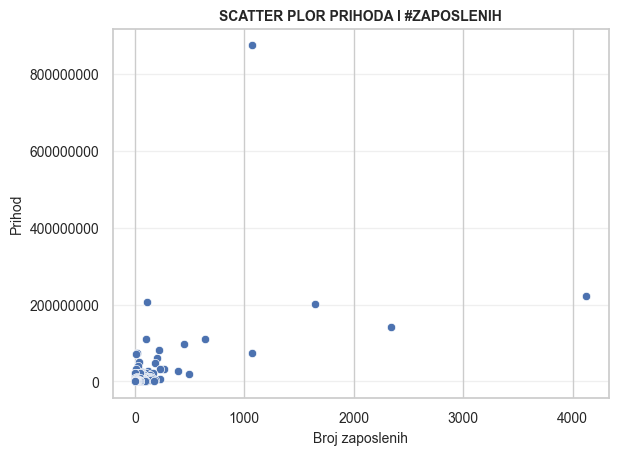

In [ ]:
sns.scatterplot(x='broj_zaposlenih', y='prihod', data=df_analysis)

plt.xlabel('Broj zaposlenih', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('SCATTER PLOR PRIHODA I #ZAPOSLENIH', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

Zaključak

Na osnovu rezultata linearne regresije, koeficijent od 122,246.73 ukazuje na to da za svaki dodatni zaposleni, prihod raste za približno 122,246.73 jedinica. Intercept od 79,039.23 označava očekivani prihod u slučaju kada broj zaposlenih iznosi nula. Sa pozitivnim koeficijentom, ovo sugeriše postojanje pozitivne linearne povezanosti između broja zaposlenih i prihoda kompanije.

S obzirom na ove rezultate, može se zaključiti da veći broj zaposlenih ima pozitivan uticaj na prihod kompanije, odnosno, kako broj zaposlenih raste, prihod takođe raste.

Nulta hipoteza (H₀): Ne postoji linearna povezanost između broja zaposlenih i prihoda.

Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

Na osnovu analize, možemo odbaciti nultu hipotezu i prihvatiti alternativnu hipotezu, što znači da postoji statistički značajna linearna povezanost između broja zaposlenih i prihoda.

4.A.3. IDENTIFIKACIJA SEKTORA SA NAJNIŽIM I NAJVIŠIM PRIHODIMA

U ovoj analizi posmatra se raspodela prihoda po različitim vrstama sektora poslovanja kako bi se identifikovali sektori sa najvećim i najmanjim prihodima.

In [ ]:
print('SEKTORI SA NAJVEÇIM PRIHODIMA:')
print()

top5_sektora = (
    df_analysis.groupby('sektor')['prihod']
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)
company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

top5_sektora = top5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
top5_sektora = top5_sektora.merge(company_count, on='sektor', how='left')

top5_sorted = top5_sektora.sort_values(by='prihod', ascending=False)

for i, row in top5_sorted.iterrows():
    print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
          f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
          f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJVEÇIM PRIHODIMA:

- Sektor 92 (Kockanje i klađenje):
  Prosečan prihod: 37444141.0
  Broj kompanija: 2

- Sektor 09 (Uslužne delatnosti u rudarstvu i geološkim istraživanjima):
  Prosečan prihod: 34258171.8
  Broj kompanija: 5

- Sektor 27 (Proizvodnja električne opreme):
  Prosečan prihod: 28702296.12
  Broj kompanija: 8

- Sektor 32 (Ostale prerađivačke delatnosti):
  Prosečan prihod: 12812460.67
  Broj kompanija: 9

- Sektor 10 (Proizvodnja prehrambenih proizvoda):
  Prosečan prihod: 8854331.41
  Broj kompanija: 34



In [ ]:
print('SEKTORI SA NAJMANJIM PRIHODIMA:')
print()

bottom5_sektora = (
    df_analysis.groupby('sektor')['prihod']
    .mean()
    .sort_values(ascending=False)
    .tail(5)
    .reset_index()
)

company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

bottom5_sektora = bottom5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
bottom5_sektora = bottom5_sektora.merge(company_count, on='sektor', how='left')

top5_sorted = bottom5_sektora.sort_values(by='prihod', ascending=True)

for i, row in top5_sorted.iterrows():
    print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
          f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
          f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJMANJIM PRIHODIMA:

- Sektor 03 (Ribarstvo i akvakulture):
  Prosečan prihod: 15596.0
  Broj kompanija: 1

- Sektor 30 (Proizvodnja ostalih saobraćajnih sredstava):
  Prosečan prihod: 21650.5
  Broj kompanija: 2

- Sektor 15 (Proizvodnja kože i predmeta od kože):
  Prosečan prihod: 25424.0
  Broj kompanija: 1

- Sektor 88 (Socijalna zaštita bez smeštaja):
  Prosečan prihod: 34084.5
  Broj kompanija: 2

- Sektor 50 (Vodeni saobraćaj):
  Prosečan prihod: 67175.0
  Broj kompanija: 2



4.A.4. PROSEČNI PRIHODI PO ZAPOSLENOM PREMA SEKTORU POSLOVANJA



----------------- NE VALJA STARII TEKST -----------------
Poređenje broja zaposlenih prema delatnosti poslovanja omogućava analizu veze između broja radnika i specifičnosti industrije.
Hipoteza: Sektori sa većim obimom poslovanja ili specifičnim potrebama često zahtevaju veći broj zaposlenih, dok manji ili efikasniji sektori mogu operisati sa manjim brojem radnika.
Ovaj pregled pomaže u identifikaciji obrazaca zapošljavanja unutar različitih industrija i može biti koristan za procenu resursnih potreba po sektorima.

In [ ]:
bottom5_sektora

,sektor,prihod,sifra,opis,company_count
0,50,"67,175.00",50,Vodeni saobraćaj,2
1,88,"34,084.50",88,Socijalna zaštita bez smeštaja,2
2,15,"25,424.00",15,Proizvodnja kože i predmeta od kože,1
3,30,"21,650.50",30,Proizvodnja ostalih saobraćajnih sredstava,2
4,03,"15,596.00",03,Ribarstvo i akvakulture,1


4.A.5. Analiza izolovanih slučajeva (outlier amaliza)

#### 4.B. Rashodi

4.B.1. Sektori i industrije sa najvišim i najnižim operativnim rashodima.

#### 4.C. Neto dobit


4.C.1. Najprofitabilnije i najmanje profitabilni sektori i industrije.


4.C.2. Neto dobit i broj zaposlenih. -- da li je optimalna utilitizacija zaposlenih u konververziji prihoda u neto dobit


4.C.D. Povezanost boniteta i neto dobiti kompanija.

4.C.5. Analiza izolovanih slučajeva (outlier): kompanije sa ekstremno visokim prihodom, ali niskom neto maržom.

#### 4.D. Amortizacija kao pokazatelj kapitalnih investiranja

4.D.1. Analiza povezanosti vrednosti amortizacije i prihoda, po sektoru, veličini i bonitetu

4.D.2. Prossečan neto povraćaj na kapitalna ulaganja.

4.D.3. Prosečna kapitalna ulaganja po zaposlenom po sektoru poslovanja.

4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja.

4.E.5. Marža kamate i poreza. veličina i sektor poslovanja.

#### 4.F. Zaposleni

4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.

4.F.2. Test normalne distribucije zaposlenih po prihodima

4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.

4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja

#### F. Zaposleni

4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.

4.F.2. Test normalne distribucije zaposlenih po prihodima.

4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.

4.F.4. Prosečan broj zaposlenih prema dekadi osnivanja.

#### G. Ostalo

4.G.1. NUMERIČKI PRIKAZ KOMPANIJA PREMA VELIČINI

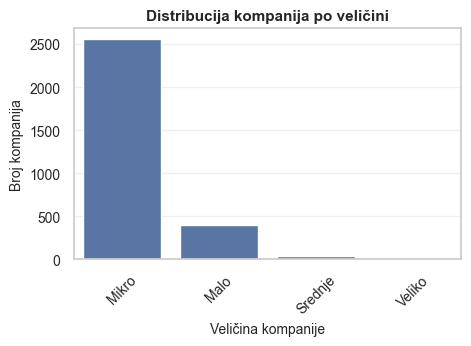

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_analysis, x='velicina', order=df_analysis['velicina'].value_counts().index)

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Broj kompanija', fontsize=10)
plt.title('Distribucija kompanija po veličini', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

4.G.2. NUMERIČKI PRIKAZ KOMPANIJA PO BONITETNOJ OCENI

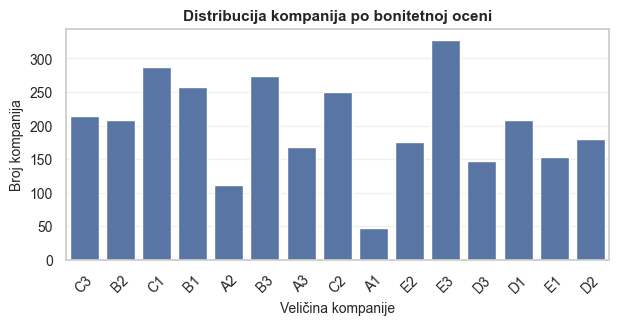

In [ ]:
plt.figure(figsize=(7, 3))
sns.countplot(data=df_analysis, x='bonitet')

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Broj kompanija', fontsize=10)
plt.title('Distribucija kompanija po bonitetnoj oceni', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

4.G.3. Najzastupljeniji sektori i industrije novosadskih kompanija.

In [ ]:
most_common_sectors = (
    df_analysis['sektor'].value_counts()
    .head(10)
    .reset_index(name='broj_kompanija')
    .rename(columns={'index': 'sektor'})
    .merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
)

most_common_sectors['opis'] = most_common_sectors['opis'].str.split('[,;]').str[0]
most_common_sectors.drop(columns=['sifra', 'sektor'], inplace=True)

df_analysis['industrija'] = df_analysis['industrija'].astype(str)
most_common_industries = (
    df_analysis['industrija'].value_counts()
    .head(10)
    .reset_index(name='broj_kompanija')
    .rename(columns={'index': 'industrija'})
    .merge(delatnosti_df[['sifra', 'opis']], left_on='industrija', right_on='sifra', how='left')
)

most_common_industries['opis'] = most_common_industries['opis'].str.extract(r'^(.{0,40}(?:\s|$))')[0].str.strip()
most_common_industries.drop(columns=['sifra'], inplace=True)

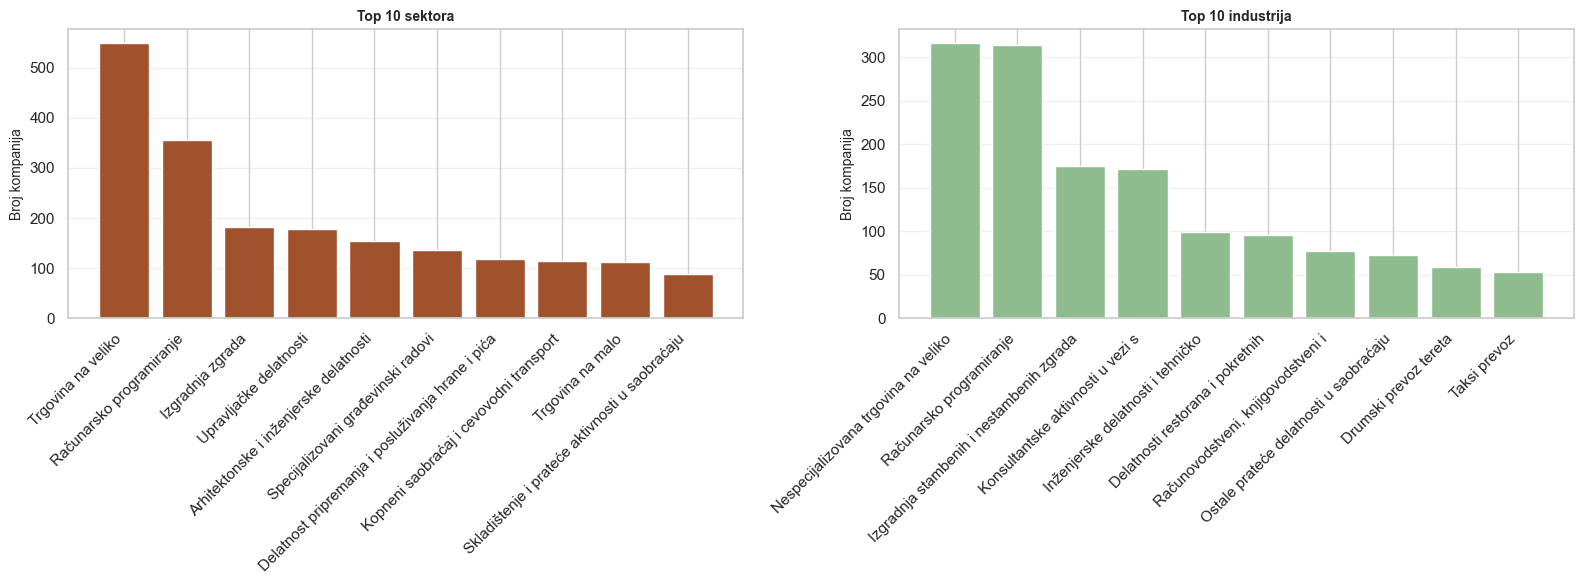

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Sektori
ax1.bar(most_common_sectors['opis'], most_common_sectors['broj_kompanija'], color='Sienna')
ax1.set_title('Top 10 sektora', fontsize=10, fontweight='bold')
ax1.set_ylabel('Broj kompanija', fontsize=10)
ax1.set_xticks(range(len(most_common_sectors)))
ax1.set_xticklabels(most_common_sectors['opis'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Industrije
ax2.bar(most_common_industries['opis'], most_common_industries['broj_kompanija'], color='DarkSeaGreen')
ax2.set_title('Top 10 industrija', fontsize=10, fontweight='bold')
ax2.set_ylabel('Broj kompanija', fontsize=10)
ax2.set_xticks(range(len(most_common_industries)))
ax2.set_xticklabels(most_common_industries['opis'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
trend_df = df_analysis.groupby('dekada_osnivanja').agg({
    'prihod': 'mean',
    'neto_dobit': 'mean',
    'broj_zaposlenih': 'mean',
    'ebit': 'mean',
    'ebitda': 'mean',
    'operativni_rashodi': 'mean',
    'amortizacija': 'mean',
    'net_marza': 'mean',
    'ebit_marza': 'mean',
    'ebitda_marza': 'mean',
    'marza_amortizacije': 'mean',
    'marza_kamate_poreza': 'mean'
}).reset_index()

KeyError: 'dekada_osnivanja'

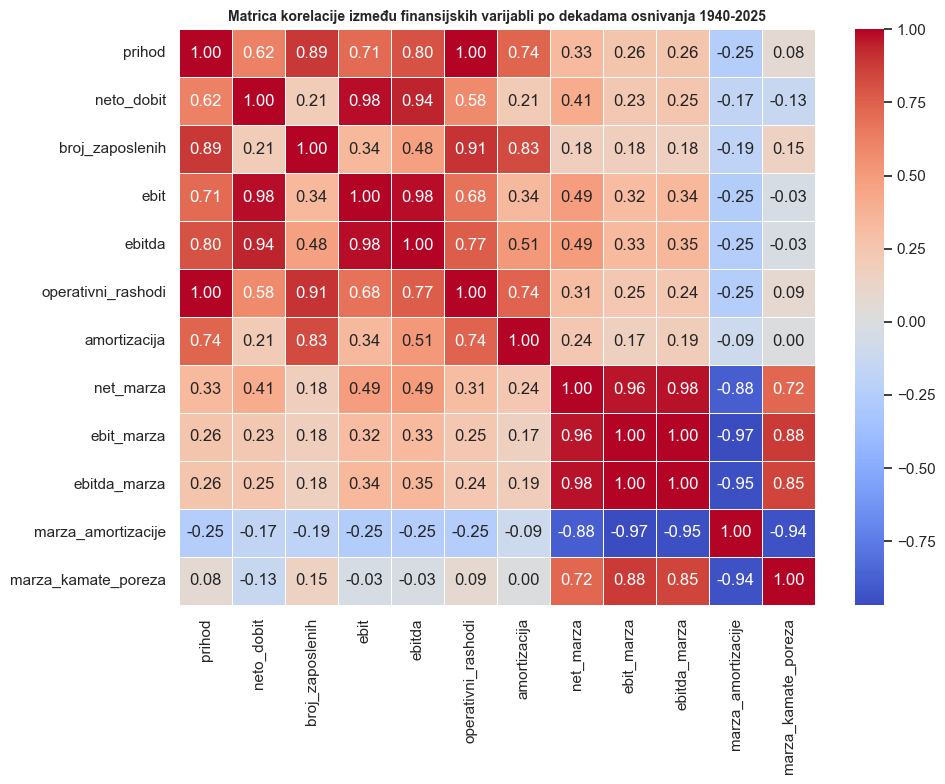

In [ ]:
correlation_matrix = trend_df.drop(columns=['dekada_osnivanja']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Matrica korelacije između finansijskih varijabli po dekadama osnivanja 1940-2025', fontsize=10, fontweight='bold')
plt.tight_layout()

plt.show()

Vizuelizacija prihoda i broja zaposlenih po dekadama

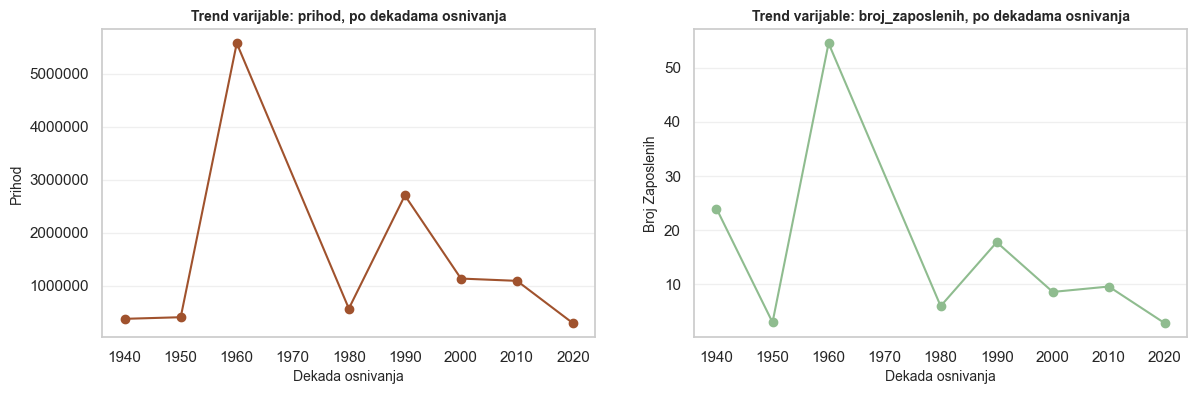

In [ ]:
var_1 = 'prihod'
var_2 = 'broj_zaposlenih'

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(trend_df['dekada_osnivanja'], trend_df[var_1], marker='o', color='Sienna')
axes[0].set_title(f'Trend varijable: {var_1}, po dekadama osnivanja', fontsize=10, fontweight='bold')

axes[0].yaxis.set_major_formatter(ScalarFormatter())
axes[0].yaxis.get_major_formatter().set_scientific(False)

axes[0].set_xlabel('Dekada osnivanja', fontsize=10)
axes[0].set_ylabel('Prihod', fontsize=10)

axes[0].grid(False) 
axes[0].grid(True, axis='y', alpha=0.3) 

# Broja zaposlenih po dekadama osnivanja
axes[1].plot(trend_df['dekada_osnivanja'], trend_df[var_2], marker='o', color='DarkSeaGreen')
axes[1].set_title(F'Trend varijable: {var_2}, po dekadama osnivanja', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Dekada osnivanja', fontsize=10)
axes[1].set_ylabel('Broj Zaposlenih', fontsize=10)

axes[1].grid(False)  
axes[1].grid(True, axis='y', alpha=0.3) 

plt.show()


### 5. ANALIZA SEKTORA IZ GRUPE NAJPROFITABILNIJIH

Pre izbora sektora na kojem će biti primenjeni analitički postupci, neophodno je filtrirati podatke za primenu tih postupaka.

FILTRIRANJE

Filtiranje podataka biće postignuto isključenjem velikih kompanija sa nesrazmernim uticajem na ukupne finansijske pokazatelje, eliminacijom kompanija sa 0 zaposlenih i isključenjem ekstremnih vrednosti u broju zaposlenih, pod uslovom da njihov prihod nije značajan za skup podataka, kako bi se očuvala reprezentativnost uzorka.

FILTRIRANJE I UKLANJANJE EKSTREMNIH VREDNOSTI IZ SKUPA
- Brisanje velikih kompanija
- Brisanje kompanija sa 0-1 zaposlenih i kompanija sa velikim brojem zaposlenih, ukoliko je to prihvatljivo
- Uklanjanje ekstremnih vrednosti kroz Z-score metodologiju (prihodi i zaposleni)

#### IZBOR SEKTORA ZA ANALIZU

S obzirom na heterogenost skupa podataka, segmentacija po sektorima omogućava validniju i smisleniju analizu. 

Za dalju analizu odabrana je delatnost **trgovine na veliko**, s obzirom na njenu stabilnost, značajan udeo u lokalnoj privredi i relativno homogenu strukturu poslovanja. Ovaj sektor ima veliki broj aktivnih firmi sa pouzdanim i uporedivim finansijskim pokazateljima, što omogućava validniju analizu i relevantnije zaključke.


In [ ]:
df_segment = df_features.copy()

In [ ]:
df_segment.drop(columns='godina_osnivanja', inplace=True)

In [ ]:
df_segment = df_segment[df_segment['velicina'] != 'Veliko']

In [ ]:
ukupan_prihod = df_segment['prihod'].sum()

prihod_0_zaposlenih = df_segment[df_segment['broj_zaposlenih'] == 0]['prihod'].sum()
udeo_zaposleni_lower = prihod_0_zaposlenih / ukupan_prihod * 100

print(f"Udeo prihoda kompanija sa 0 zaposlenih je: {udeo_zaposleni_lower:.2f}%") 

prihod_iznad_200_zaposlenih = df_segment[df_segment['broj_zaposlenih'] > 200]['prihod'].sum()
udeo_zaposleni_upper = prihod_iznad_200_zaposlenih / ukupan_prihod * 100

print(f"Udeo prihoda kompanija sa više od 200 zaposlenih je: {udeo_zaposleni_upper:.2f}%")

Donji i gornji ekstremi kompanija u smislu broja zaposlenih će biti isključeni iz skupa je mogu narušiti reprezentativnost uzorka, a testiranje njihovog učešća u ukupnih prihodima čini ovo isključenje analitički prihvatljivim.

U sledećem koraku proveravamo exkstremne vrednosti direktno na prihodima primenom z-skor metode.

In [ ]:
df_segment = df_segment[df_segment['broj_zaposlenih'] != 0]

df_segment = df_segment[df_segment['broj_zaposlenih'] < 200]

Z-SKOR filtriranje

In [ ]:
ukupan_prihod = df_segment['prihod'].sum()

df_segment['zscore_prihod'] = zscore(df_segment['prihod'])

prihod_outliers = df_segment[df_segment['zscore_prihod'].abs() > 3]

prihod_outliers = prihod_outliers['prihod'].sum() / ukupan_prihod * 100

print(f"Udeo prihoda outliera u ukupnim prihodima je: {prihod_outliers:.2f}%")

Zaključak o eliminaciji ekstremnih vrednosti

Na osnovu testiranja Z-skor metodologije, utvrđeno je da primenom standardne vrednosti Z-skor praga od 3, koja eliminiše ekstremne vrednosti, bi se eliminisalo oko 33.50% kompanija po prihodima. Ovo ukazuje da su prema kriterijumu prihoda ekstremne vrednosti već eliminisane, stoga dalji postupci eliminacije ekstrema neće biti sprovedeni.

#### H. Klaster analiza.

Priprema i enkodiranje podataka